## dataset seq_len 512

In [4]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
from transformers import DataCollatorForLanguageModeling

In [5]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [6]:
device = torch.device('cuda:1')

In [7]:
!curl https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip -o wikitext-103-raw-v1.zip

!unzip wikitext-103-raw-v1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 10  183M   10 18.5M    0     0  2824k      0  0:01:06  0:00:06  0:01:00 3312k^C
Archive:  wikitext-103-raw-v1.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of wikitext-103-raw-v1.zip or
        wikitext-103-raw-v1.zip.zip, and cannot find wikitext-103-raw-v1.zip.ZIP, period.


In [10]:
import os
from tqdm import tqdm
def evaluate(model, dataset_valid, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)

    eval_dataset = dataset_valid
    eval_batch_size = 2
    eval_sampler = SequentialSampler(eval_dataset)

    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size, collate_fn = data_collator, pin_memory=True, num_workers=4)

    # Eval!
    
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    model.eval()
    losses = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['input_ids'], batch['labels']#(batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    #perplexity = perplexity / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))


    result = {
        "perplexity": perplexity,
        "loss":eval_loss
    }
    return result

In [11]:
from transformers import TextDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#dataset_train = TextDataset(tokenizer=tokenizer, 
                                #file_path="/notebook/greenAI/wikitext-103/wiki.train.tokens", 
                                #block_size=512)

dataset_test = TextDataset(tokenizer=tokenizer, 
                                file_path="/notebook/greenAI/scalable_low_experiments/wikitext-103-raw/wiki.test.raw", 
                                block_size=512)


/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [12]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [13]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [42]:
evaluate(model.to(torch.device('cuda:1')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 244/244 [00:03<00:00, 72.89it/s]


{'perplexity': tensor(51.7823), 'loss': 3.947048593739994}

In [7]:
def estimate(model_name):
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    metric = evaluate(model.to(torch.device('cuda:1')), dataset_test, tokenizer)
    num_param = sum(p.numel() for p in model.parameters())
    return {"model_name": model_name, "num_param": num_param, "metric": metric}

In [8]:
scores = []
for model_name in ["gpt2", "gpt2-medium", "gpt2-large", "distilgpt2", "sberbank-ai/mGPT"]:
    a = estimate(model_name)
    scores.append(a)
    print (a)

Evaluating: 100%|██████████| 280/280 [00:06<00:00, 42.91it/s]


{'model_name': 'gpt2', 'num_param': 124439808, 'metric': {'perplexity': tensor(34.5494), 'loss': 3.542391267844609}}


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 280/280 [00:14<00:00, 19.88it/s]


{'model_name': 'gpt2-medium', 'num_param': 354823168, 'metric': {'perplexity': tensor(24.7295), 'loss': 3.2079955305371968}}


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 280/280 [00:25<00:00, 11.19it/s]


{'model_name': 'gpt2-large', 'num_param': 774030080, 'metric': {'perplexity': tensor(21.4951), 'loss': 3.0678251326084136}}


Evaluating: 100%|██████████| 280/280 [00:04<00:00, 63.10it/s]


{'model_name': 'distilgpt2', 'num_param': 81912576, 'metric': {'perplexity': tensor(51.1908), 'loss': 3.935559701919556}}


Evaluating: 100%|██████████| 280/280 [00:35<00:00,  7.86it/s]

{'model_name': 'sberbank-ai/mGPT', 'num_param': 1417596928, 'metric': {'perplexity': tensor(14809.6318), 'loss': 9.60303327356066}}


In [34]:
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
print('Load model')
external_model = GPT2LMHeadModel.from_pretrained("distilgpt2")

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Load model


In [35]:
num_param = sum(p.numel() for p in external_model.parameters())

In [36]:
num_param

81912576

In [37]:
metric = evaluate(external_model.to(torch.device('cuda:1')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 280/280 [00:04<00:00, 64.39it/s]


In [38]:
metric

{'perplexity': tensor(51.1908), 'loss': 3.935559701919556}

In [ ]:
gpt-2 small	124439808	34.54
gpt-2 med	354823168	24.72
gpt-2 large	774030080	21.49
gpt-2 distill	81912576	51.19
mgpt	1417596928	14809.6318
opt 1.5 B	1315758080	19.53
opt 1350m	331196416	30.02
opt 2.7 B	2651596800	16.88

## Plots

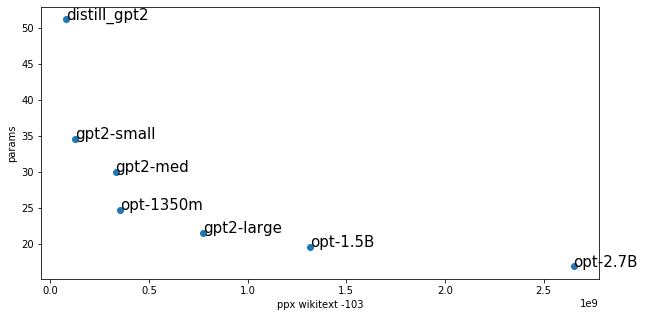

In [3]:
import matplotlib.pyplot as plt
y = [51.19, 34.54, 30.02, 24.72, 21.49, 19.53, 16.88]
z = [81912576, 124439808, 331196416, 354823168, 774030080, 1315758080, 2651596800]
n = ['distill_gpt2', 'gpt2-small', 'gpt2-med', 'opt-1350m','gpt2-large', 'opt-1.5B', 'opt-2.7B']
sizes = [15, 15, 15, 15, 15, 15, 15]


fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(z, y)

ax.set_ylabel('params')
ax.set_xlabel('ppx wikitext -103')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), fontsize=sizes[i])
    
fig.savefig('ax2_figure.png')

## opt

In [1]:
import transformers

In [2]:
!pip3 install transformers --q

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
transformers.__version__

'4.5.0'

In [4]:
from transformers import OPTForCausalLM, GPT2Tokenizer

ImportError: cannot import name 'OPTForCausalLM' from 'transformers' (unknown location)

In [38]:
model_name_or_path = "facebook/opt-1.3b"

tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = OPTForCausalLM.from_pretrained(model_name_or_path).to(DEVICE)

model.gradient_checkpointing_enable() 

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/441 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/685 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

NameError: name 'OPTForCausalLM' is not defined

## regular

In [29]:
import sys
sys.path
sys.path.append('/notebook/greenAI/')
print(sys.path)

['/notebook/greenAI/all_small_chekpoints', '/notebook/greenAI/all_small_chekpoints', '/notebook', '/opt/.pyenv/versions/3.7.4/lib/python37.zip', '/opt/.pyenv/versions/3.7.4/lib/python3.7', '/opt/.pyenv/versions/3.7.4/lib/python3.7/lib-dynload', '', '/root/.local/lib/python3.7/site-packages', '/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages', '/notebook/transformers/src', '/notebook/torch', '/notebook/tensorly', '/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/notebook/greenAI/', '/notebook/greenAI/', '/notebook/greenAI/']


In [12]:
from help_trainer import evaluate

In [30]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
from src.classes.gpt2_tt import GPT2_TT_Model
# Initializing a GPT2 configuration
configuration = GPT2Config()



In [31]:
# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration)

# Accessing the model configuration
configuration = model.config

In [32]:
import torch
model.load_state_dict(torch.load('/notebook/greenAI/small_chekpoints/rank_0/checkpoint_best/model_tt.pth'))


<All keys matched successfully>

In [33]:
evaluate(args, model.to(torch.device('cuda:4')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 279/279 [00:12<00:00, 21.82it/s]


{'perplexity': tensor(17.6614), 'loss': 2.871383121791279}

## rank 16

In [36]:
import torch
from src.classes.gpt2_tt import GPT2_TT_Model

model = GPT2_TT_Model(configuration, rank = 16)

torch.Size([768, 3072])
(2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (3, 12)]
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (12, 3)]
torch.Size([768, 3072])
(2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (3, 12)]
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (12, 3)]
torch.Size([768, 3072])
(2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (3, 12)]
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (12, 3)]
torch.Size([768, 3072])
(2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (3, 12)]
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2, 2, 3)
[(4, 4), (4, 4), (4, 4), (4, 4), (12, 3)]
torch.Size([768, 3072])
(2, 2, 2, 2, 2, 2, 2, 2, 3) (2, 2, 2, 2, 2, 2, 2

In [28]:
model.load_state_dict(torch.load('/notebook/greenAI/small_chekpoints/rank_16/checkpoint-116000/model_tt.pth'))
evaluate(args, model.to(torch.device('cuda:4')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 279/279 [00:15<00:00, 18.03it/s]


{'perplexity': tensor(21.6283), 'loss': 3.0740016809928377}

## rank 128

In [ ]:
import torch
from src.classes.gpt2_tt import GPT2_TT_Model

model = GPT2_TT_Model(configuration, rank = 128)

In [26]:
model.load_state_dict(torch.load('/notebook/greenAI/small_chekpoints/rank128/checkpoint_best/model_tt.pth'))
evaluate(args, model.to(torch.device('cuda:4')), dataset_test, tokenizer)

Evaluating: 100%|██████████| 279/279 [00:14<00:00, 18.94it/s]


{'perplexity': tensor(18.0561), 'loss': 2.8934844305011107}